# 🔥 Ejemplo de Entrenamiento ViT con timm
Usando `timm` para entrenar un Vision Transformer sobre imágenes clasificadas del dataset FLAME.

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

c:\Users\TestUser\Documents\MAESTRIA\vit_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 30
best_acc = 0.0  # Para guardar el mejor modelo


In [6]:
# Transforms y Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder("../data/Training", transform=transform)
val_ds = datasets.ImageFolder("../data/Test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

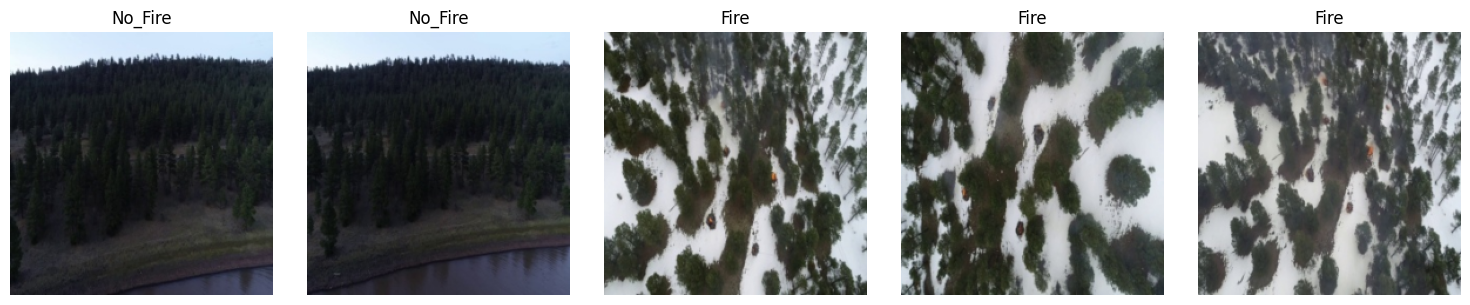

In [7]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
import random

# Transformación igual a la del entrenamiento (sin normalizar para visualización)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Ruta al dataset de entrenamiento
train_ds = datasets.ImageFolder("../data/Training", transform=transform)

# Seleccionar 5 imágenes aleatorias
indices = random.sample(range(len(train_ds)), 5)
samples = [train_ds[i] for i in indices]

# Mostrar las imágenes y sus clases
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (img_tensor, label) in enumerate(samples):
    axs[i].imshow(to_pil_image(img_tensor))
    axs[i].set_title(train_ds.classes[label])
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# modelo ViT desde timm
model = timm.create_model('swin_tiny_patch16_224', pretrained=True, num_classes=2)
model.to(device)

c:\Users\TestUser\Documents\MAESTRIA\vit_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TestUser\.cache\huggingface\hub\models--timm--deit_tiny_patch16_224.fb_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Calcular pesos inversamente proporcionales a la frecuencia
fire_count = 25018
no_fire_count = 14357
total = fire_count + no_fire_count

# Ponderación: menos imágenes → mayor peso
weight_fire = total / (2 * fire_count)
weight_no_fire = total / (2 * no_fire_count)

weights = torch.tensor([weight_fire, weight_no_fire]).to(device)

# ✅ Función de pérdida ponderada
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizador
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Entrenamiento
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Evaluación en validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Guardar mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_deit_model.pth")
        print("Nuevo mejor modelo guardado.")


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

              precision    recall  f1-score   support

        Fire       0.70      0.87      0.78      5137
     No_Fire       0.70      0.44      0.54      3480

    accuracy                           0.70      8617
   macro avg       0.70      0.66      0.66      8617
weighted avg       0.70      0.70      0.68      8617



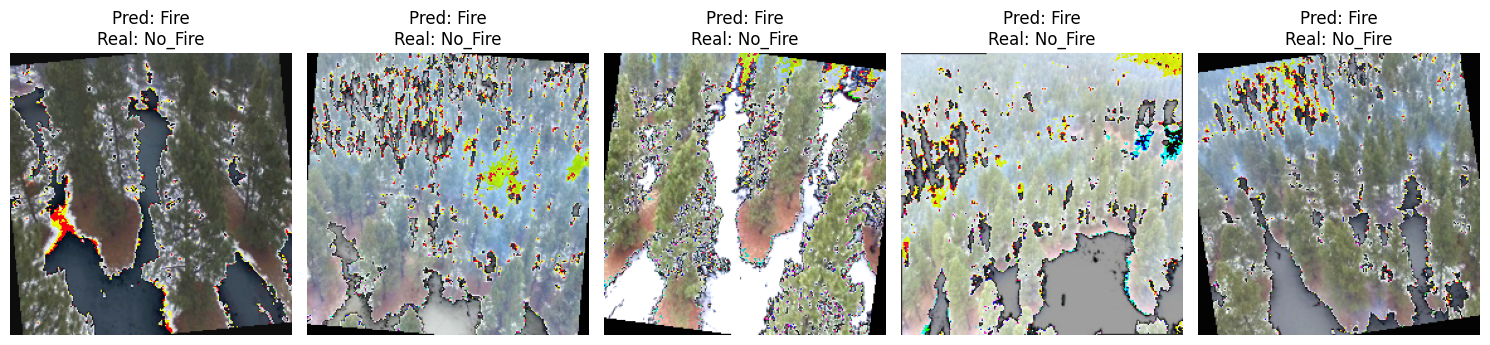

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Guardar imágenes mal clasificadas
wrong_samples = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred != true:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Seleccionar y mostrar 5 errores aleatorios (o menos si hay pocos)
n = min(5, len(wrong_samples))
samples_to_show = random.sample(wrong_samples, n)

# Mostrar visualmente
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(samples_to_show):
    axs[i].imshow(to_pil_image(img_tensor))
    axs[i].set_title(f"Pred: {train_ds.classes[pred]}\nReal: {train_ds.classes[true]}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


In [33]:
print(train_ds.classes)  # ['Fire', 'No_Fire']


['Fire', 'No_Fire']


In [57]:
from PIL import Image

# Ruta de la imagen que quieres predecir
image_path = "../data/Test/No_Fire/resized_test_nofire_frame21.jpg"
# image_path = "../data/Test/Fire/resized_test_fire_frame5017.jpg"
# image_path = "../data/mydata/real_nofire1.jpg"

# Preprocesamiento (debe ser igual al del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Abrir imagen y preparar
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Inferen
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

#resultado
class_names = train_ds.classes  
print(f"La imagen fue clasificada como: {class_names[pred_class]}")

La imagen fue clasificada como: No_Fire


In [14]:
# Guardar modelo al final del entrenamiento
torch.save(model.state_dict(), "modelo_entrenado_vit.pth")
print("Modelo guardado en: modelo_entrenado_vit.pth")

Modelo guardado en: modelo_entrenado_vit.pth


In [ ]:
model = MiModeloViT()  # instancia igual al original
model.load_state_dict(torch.load("modelo_entrenado_vit.pth"))
model.to(device)
model.eval()

In [1]:
import torch
print(torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

2.7.1+cpu
CUDA disponible: False


In [2]:
import torch
print(torch.__version__)  # Debería decir algo como 2.1.0+cu118
print(torch.cuda.is_available())  # Esto debe dar: True
print(torch.cuda.get_device_name(0))  # Te dirá el nombre de tu GPU

2.1.0+cu121
True
NVIDIA GeForce RTX 3070
